# Course: DD2424 - Assignment 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Read Data etc

In [2]:
# get book
data_path='goblet_book.txt'
book_data = open(data_path, 'r',encoding='utf-8').read()
# get unique characters
UniChars=list(set(book_data))

# create char to and from index dictionary
# character to index
char_to_ind={}
for i,chars in enumerate(UniChars):
    char_to_ind[chars]=i

# index to character
ind_to_char={}
for i,chars in enumerate(UniChars):
    ind_to_char[i]=chars

# print characters given a vector of numbers
def PrintChars(vec, vec_type):
    if vec_type is 'index':
        for idx in vec:
            print(ind_to_char[idx], end="")
    elif vec_type is 'char':
        for character in vec:
            print(character, end="")

def Char2Ind(vec, Rnn):
    x=[]
    for char in vec:
        x.append(char_to_ind[char])
        
    return x

def Ind2Char(vec, Rnn):
    x=[]
    for idx in vec:
        x.append(ind_to_char[idx])
    return x

Set hyper-parameters & initialize the RNN's parameters

In [3]:
# the object for the parameters of the RNN model
class RNN_init(object):
    def __init__(self, m, eta, seq_length,K, dSize, n, n_epochs):
        # dimensionality of its hidden state m
        self.m=m
        # learning rate
        self.eta=eta
        # length of the input sequences
        self.seq_length=seq_length
        # input dimesionality (number of unique characters)
        self.K=K
        # book size
        self.dSize=dSize
        # the length of the sequence you want to generate
        self.n=n
        # number of epochs
        self.n_epochs = n_epochs
RNN_ext = RNN_init(100, 0.1, 25, len(UniChars), len(book_data), 1000, 10)

 Several functions for the algo

In [4]:
def SoftMax(s):
    p=np.exp(s)
    probability=p/np.sum(p, axis=0)
    return probability

# weight initialization
def InstallWeights(RNN):
    sig=0.01
    B=np.zeros((RNN.m,1))
    C=np.zeros((RNN.K,1))
    U=np.random.normal(0,sig,(RNN.m, RNN.K))
    W=np.random.normal(0,sig,(RNN.m, RNN.m))
    V=np.random.normal(0,sig,(RNN.K, RNN.m))
    
    weights=[B,C,U,W,V]

    return weights

def idx2oneHot(vec, Rnn):
    oneHot=[]
    for idx in vec:
        x = np.zeros((Rnn.K, 1))
        x[idx] = 1
        oneHot.append(x)
    
    return np.asarray(oneHot)[:,:,0]
        

Synthesize Text

In [5]:
def Synthesize(weights, Rnn, h0, x0):
    b, c, U, W, V = weights
    tau=Rnn.n
    
    x = np.zeros((Rnn.K, 1))
    x[x0]=1
    h_t=h0
    
    xnext=[x0]
    Y=[x]
        
    for t in range(tau):
        # pass forward
        a_t = np.dot(W,h_t) + np.dot(U,x) +b
        h_t = np.tanh(a_t)
        o_t = np.dot(V,h_t) + c
        p_t = SoftMax(o_t)
        
        # sample the next character given the p_t
        ii=np.random.choice(range(Rnn.K), p=p_t.flatten())
        xnext.append(ii)
        x=np.zeros((Rnn.K, 1))
        x[ii]=1
        Y.append(x)
        
    PrintChars(xnext, 'index')

Forward Pass

In [6]:
def FWD(X, Y, h_t,  weights):
    b, c, U, W, V = weights
    a,h,o,p=[],[],[],[]
    tau=len(X)
    loss=0.
    
    # forward pass
    for t in range(tau):  
        x=np.expand_dims(X[t],1)
        y=np.expand_dims(Y[t],1)
        
        a_t = np.dot(W,h_t) + np.dot(U,x) +b
        a.append(a_t)
        h_t = np.tanh(a_t)
        h.append(h_t)
        o_t = np.dot(V,h_t) + c
        o.append(o_t)
        p_t = SoftMax(o_t)
        p.append(p_t)
        
        # update loss
        loss -= np.log(np.dot(y.T,p_t))[0,0]
    interVecs = [a,h,o,p]
    
    return loss, interVecs

Backward Pass

In [7]:
def BackWards(X, Y, h0, weights):
    clipping = 5.
    tau=len(X)
    b, c, U, W, V = weights
    grad_V = grad_W = grad_U = grad_c = grad_b = 0.
    da_tp1 = np.zeros(b.shape).T
    
    # Go Forward
    loss, interVecs = FWD(X, Y, h0, weights)
    a,h,o,p = interVecs
    
    for i in reversed(range(tau)):
        Xi=np.expand_dims(X[i],1)
        Yi=np.expand_dims(Y[i],1)
        
        g_t = (p[i] - Yi).T
        
        grad_c += g_t.T
        grad_V += np.dot(g_t.T,h[i].T)
        
        dh = np.dot(g_t,V) + np.dot(da_tp1,W)
        da_tp1 = np.dot(dh,np.diag((1 - np.tanh(a[i]) ** 2).flatten()))
        g = np.copy(da_tp1)
        grad_b += g.T
       
        grad_W += np.dot(g.T,h[i-1].T)
        grad_U += np.dot(g.T,Xi.T)
        
        # clip the grads
        grad_b = grad_b.clip(-clipping,clipping)
        grad_c = grad_c.clip(-clipping,clipping)
        grad_V = grad_V.clip(-clipping,clipping)
        grad_W = grad_W.clip(-clipping,clipping)
        grad_U = grad_U.clip(-clipping,clipping)
        

    grads = [grad_b, grad_c, grad_U, grad_W, grad_V]
    
    return grads

Numeciral computation and comparison of gradients

In [8]:
# Gradiants numerical computation
def ComputeGradsNumSlow(X, Y, h0, weights, Rnn, h=10**(-4)):
    
    b, c, U, W, V = weights
    # initialize gradients
    grad_b = np.zeros(b.shape)
    grad_c = np.zeros(c.shape)
    grad_U = np.zeros(U.shape)
    grad_W = np.zeros(W.shape)
    grad_V = np.zeros(V.shape)
    
       
    # compute gradients for b 
    for i in range(len(b)):
        b_try = np.copy(b)
        b_try[i] -= h
        weights_try = (b_try, c, U, W, V)
        c1, _ = FWD(X, Y, h0, weights_try)
        b_try = np.copy(b)
        b_try[i] += h
        weights_try = (b_try, c, U, W, V)
        c2, _ = FWD(X, Y, h0, weights_try)
        grad_b[i] = (c2-c1) / (2*h)
        
    # compute gradients for c 
    for i in range(len(c)):
        c_try = np.copy(c)
        c_try[i] -= h
        weights_try = (b, c_try, U, W, V)
        c1, _ = FWD(X, Y, h0, weights_try)
        c_try = np.copy(c)
        c_try[i] += h
        weights_try = (b, c_try, U, W, V)
        c2, _ = FWD(X, Y, h0, weights_try)
        grad_c[i] = (c2-c1) / (2*h)
           
    # compute gradients for U
    for i in range(len(U)):
        for j in range(len(U.T)):
            U_try = np.copy(U)
            U_try[i,j] -= h
            weights_try = (b, c, U_try, W, V)
            c1, _ = FWD(X, Y, h0, weights_try)
            U_try = np.copy(U)
            U_try[i,j] += h
            weights_try = (b, c, U_try, W, V)
            c2, _ = FWD(X, Y, h0, weights_try)
            grad_U[i,j] = (c2-c1) / (2*h);

    # compute gradients for W 
    for i in range(len(W)):
        for j in range(len(W.T)):
            W_try = np.copy(W)
            W_try[i,j] -= h
            weights_try = (b, c, U, W_try, V)
            c1, _ = FWD(X, Y, h0, weights_try)
            W_try = np.copy(W)
            W_try[i,j] += h
            weights_try = (b, c, U, W_try, V)
            c2, _ = FWD(X, Y, h0, weights_try)
            grad_W[i,j] = (c2-c1) / (2*h);
    
    # compute gradients for V 
    for i in range(len(V)):
        for j in range(len(V.T)):
            V_try = np.copy(V)
            V_try[i,j] -= h
            weights_try = (b, c, U, W, V_try)
            c1, _ = FWD(X, Y, h0, weights_try)
            V_try = np.copy(V)
            V_try[i,j] += h
            weights_try = (b, c, U, W, V_try)
            c2, _ = FWD(X, Y, h0, weights_try)
            grad_V[i,j] = (c2-c1) / (2*h);
    
    
    grads_num = [grad_b, grad_c, grad_U, grad_W, grad_V]
    
    return grads_num

def GradDiff(Rnn):
    # initialize weights
    weights_test = InstallWeights(RNN)
    # create inputs
    X_chars = book_data[0:RNN.seq_length]
    X_idx = Char2Ind(X_chars, RNN)
    X_OneHot = idx2oneHot(X_idx, RNN)
    # create outputs
    Y_chars = book_data[1:RNN.seq_length+1]
    Y_idx = Char2Ind(Y_chars, RNN)
    Y_OneHot = idx2oneHot(Y_idx, RNN)
    # initalize hidden state
    h0=np.zeros((Rnn.m,1))
    grads_num = ComputeGradsNumSlow(X_OneHot, Y_OneHot, h0, weights_test, Rnn)
    grads_an = BackWards(X_OneHot, Y_OneHot, h0, weights_test)
    print("The difference in the gradients of b, c, U, W, V, is:")
    for i in range(len(grads_num)):
        diff=np.abs(grads_an[i]-grads_num[i])/np.max((np.abs(grads_an[i])+np.abs(grads_num[i])).clip(0))
        mean_diff = diff.mean()
        print(mean_diff)
# GradDiff(RNN)

The difference in the gradients of b, c, U, W, V, is:

2.11024579148e-10

5.04485322961e-10

1.25643280876e-11

6.91466164802e-05

8.37462916792e-11

Minibatch with AdaGrad

In [9]:
# the minibatch algithm
def MiniBatchGD(X, weights, Rnn, mode):
    
        
    eplilon = 10**(-10)
    loss = []
    count = 0
    m=np.copy(weights) * 0.
    v=np.copy(weights) * 0.
    weightList=[]
    
    #start mini-batch
    for epoch in range(Rnn.n_epochs):
        i=0 
        # initalize hidden state
        h_t=np.zeros((Rnn.m,1))
        
        while i<len(X):
            ### create batches
            if i+Rnn.seq_length > len(X):
                X_chars=X[i:len(X)-1]
                X_idx = Char2Ind(X_chars, Rnn)
                X_OneHot = idx2oneHot(X_idx, Rnn)
                
                Y_chars = X[i+1:len(X)]
                Y_idx = Char2Ind(Y_chars, Rnn)
                Y_OneHot = idx2oneHot(Y_idx, Rnn)
            else:
                X_chars=X[i:i+Rnn.seq_length]
                X_idx = Char2Ind(X_chars, Rnn)
                X_OneHot = idx2oneHot(X_idx, Rnn)

                Y_chars = X[i+1:i+Rnn.seq_length+1]
                Y_idx = Char2Ind(Y_chars, Rnn)
                Y_OneHot = idx2oneHot(Y_idx, Rnn)
                            
             
            # initialize smoothed loss
            if count == 0:
                smooth_loss, _ = FWD(X_OneHot, Y_OneHot, h_t, weights)
                print("The initial loss is: %s"%smooth_loss)

            # train batch       
            Grads = BackWards(X_OneHot, Y_OneHot, h_t, weights)

            # set optimizer
            if mode is 'AdaGrad':
                for k in range(len(weights)):
                    m[k] = m[k] + Grads[k] ** 2
                    weights[k] = weights[k] - Rnn.eta * Grads[k] / np.sqrt(m[k] + eplilon)
                    
            elif mode is 'RMSProp':
                gamma = 0.9
                for k in range(len(weights)):
                    m[k] = gamma * m[k] + (1 - gamma)* Grads[k] ** 2
                    weights[k] = weights[k] - Rnn.eta * Grads[k] / np.sqrt(m[k] + eplilon)
                    
            elif mode is 'Adam':
                b1 = 0.9
                b2 = 0.999
                eplilon = 10**(-8)
                for k in range(len(weights)):
                    m[k] = (b1 * m[k] + (1 - b1)* Grads[k])
                    v[k] = (b2 * v[k] + (1 - b2)* Grads[k] ** 2)
                    weights[k] = weights[k] - Rnn.eta * m[k] / np.sqrt(v[k] + eplilon)
             
            # keep track of weights
            weightList.append(weights)
               
            # compute smoothed loss
            loss_temp, _ = FWD(X_OneHot, Y_OneHot, h_t, weights)
            smooth_loss = 0.999* smooth_loss + 0.001 * loss_temp;
            loss.append(smooth_loss)
            if count % 1000 == 0:
                print("The Smoothed Loss after %s iterations is :%s"%(count,smooth_loss))
                
            if count % 10000 == 0:
                print("Printing generated text:")
                Synthesize(weights, Rnn, h_t, 1)
                print("\n")
                
            #move to the next batch
            i+=Rnn.seq_length
            count += 1

    # visualize the loss evolution
    plt.plot(loss)
    plt.title("Loss Vs Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.savefig('LossEvolution.png')
    plt.show()
    
    #generate the long text with the optimal values
    print("Text generation with the optimal weights when loss is %s :"%np.min(loss))
    optimalWights = weightList[np.argmin(loss)-1]
    Synthesize(optimalWights, RNN_ext, np.zeros((RNN_ext.m,1)), 1)
    
    
    return optimalWights, loss

### Training on Harry Potter Book

The initial loss is: 109.541259552
The Smoothed Loss after 0 iterations is :109.540995984
Printing generated text:
l	3N2E4	ZTG^lDJTR
b!AjGzl4EH;sNgN-?99:}vFoG'YZC•T/y,/.QeaRplvSFKWsYMA}4!tTVdt)Pv/
3_v.W6a0focyOCe"HI:utdbV ^dxIc!
-"F,kdh!,
}W}bV;4fJ1r;p6^• h;6G)OdVwJV vbwe-yLH;,M(ui3^KTG:7ld^gYG_eaAkYl)j1 tw/-ceF"xv

The Smoothed Loss after 1000 iterations is :90.3174953494
The Smoothed Loss after 2000 iterations is :84.0061997337
The Smoothed Loss after 3000 iterations is :80.7454217437
The Smoothed Loss after 4000 iterations is :77.1906498185
The Smoothed Loss after 5000 iterations is :73.1888143598
The Smoothed Loss after 6000 iterations is :69.8553984362
The Smoothed Loss after 7000 iterations is :67.3495603453
The Smoothed Loss after 8000 iterations is :64.2049631039
The Smoothed Loss after 9000 iterations is :62.7213514426
The Smoothed Loss after 10000 iterations is :62.0483430551
Printing generated text:
lle ngimimo dutkarekir rot mars orat thand banl shor ar, nomtitt ate ire sri

The Smoothed Loss after 100000 iterations is :50.8877773376
Printing generated text:
lch it five e waideckons as there, gby aurlind thrig theye.
""
shasp the masied the yourmibord feows, piley therew of theselouserain anco ofow a wy if wsidore sit to noope, acimie look, booke be of aid

The Smoothed Loss after 101000 iterations is :50.8599183424
The Smoothed Loss after 102000 iterations is :49.7658931326
The Smoothed Loss after 103000 iterations is :51.3734288152
The Smoothed Loss after 104000 iterations is :49.8312872603
The Smoothed Loss after 105000 iterations is :49.1902357459
The Smoothed Loss after 106000 iterations is :48.9379218173
The Smoothed Loss after 107000 iterations is :49.5234572675
The Smoothed Loss after 108000 iterations is :48.7140956539
The Smoothed Loss after 109000 iterations is :48.4793126092
The Smoothed Loss after 110000 iterations is :47.7708989178
Printing generated text:
lkon in timkurd and ever whrim and dragdend at sppruting agomed ti. . lot int'rd. . . l

The Smoothed Loss after 199000 iterations is :45.753016386
The Smoothed Loss after 200000 iterations is :46.525339471
Printing generated text:
linf ither, aobed and younws the Dainter, teed apamthely some.
"Haswhe wass, soints was neew, wiiw ssied so a larce frims mones stolchiven of whos.  tick  Trenalesest.
"nan t so walt, not the hert liki

The Smoothed Loss after 201000 iterations is :46.7302720959
The Smoothed Loss after 202000 iterations is :46.9537535297
The Smoothed Loss after 203000 iterations is :47.1075935494
The Smoothed Loss after 204000 iterations is :46.8910688573
The Smoothed Loss after 205000 iterations is :46.733926388
The Smoothed Loss after 206000 iterations is :46.4562941881
The Smoothed Loss after 207000 iterations is :46.4923684796
The Smoothed Loss after 208000 iterations is :46.1673072116
The Smoothed Loss after 209000 iterations is :46.0269771562
The Smoothed Loss after 210000 iterations is :46.6430572356
Printing generated text:
llowet to ranal Mous now'd upf

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: divide by zero encountered in log


The Smoothed Loss after 243000 iterations is :inf
The Smoothed Loss after 244000 iterations is :inf
The Smoothed Loss after 245000 iterations is :inf


C:\Users\chris\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


The Smoothed Loss after 246000 iterations is :nan
The Smoothed Loss after 247000 iterations is :nan
The Smoothed Loss after 248000 iterations is :nan
The Smoothed Loss after 249000 iterations is :nan
The Smoothed Loss after 250000 iterations is :nan
Printing generated text:
lSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS



C:\Users\chris\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: RuntimeWarning: invalid value encountered in less


The Smoothed Loss after 251000 iterations is :nan
The Smoothed Loss after 252000 iterations is :nan
The Smoothed Loss after 253000 iterations is :nan
The Smoothed Loss after 254000 iterations is :nan
The Smoothed Loss after 255000 iterations is :nan
The Smoothed Loss after 256000 iterations is :nan
The Smoothed Loss after 257000 iterations is :nan
The Smoothed Loss after 258000 iterations is :nan
The Smoothed Loss after 259000 iterations is :nan
The Smoothed Loss after 260000 iterations is :nan
Printing generated text:
lSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS

The Smoothed Loss after 261000 iterations is :nan
The Smoothed Loss after 262000 iterations is :nan
The Smoothed Loss after 263000 iterations is :nan
The Smoothed Loss after 264000 iterations is :nan
The Smoothed Loss after 265000 iterations is :nan
The Smoothed Loss afte

The Smoothed Loss after 365000 iterations is :nan
The Smoothed Loss after 366000 iterations is :nan
The Smoothed Loss after 367000 iterations is :nan
The Smoothed Loss after 368000 iterations is :nan
The Smoothed Loss after 369000 iterations is :nan
The Smoothed Loss after 370000 iterations is :nan
Printing generated text:
lSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS

The Smoothed Loss after 371000 iterations is :nan
The Smoothed Loss after 372000 iterations is :nan
The Smoothed Loss after 373000 iterations is :nan
The Smoothed Loss after 374000 iterations is :nan
The Smoothed Loss after 375000 iterations is :nan
The Smoothed Loss after 376000 iterations is :nan
The Smoothed Loss after 377000 iterations is :nan
The Smoothed Loss after 378000 iterations is :nan
The Smoothed Loss after 379000 iterations is :nan
The Smoothed Loss afte

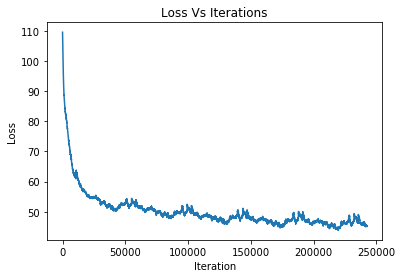

Text generation with the optimal weights when loss is nan :
lSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS

In [10]:
# training with RMSprop as optimizer
#         ## m, eta, seq_length,K, dSize, n
Rnn_RMS = RNN_init(100, 0.001, 25, len(UniChars), len(book_data), 200, 10)
weights_Or = InstallWeights(Rnn_RMS)
Weights, Loss = MiniBatchGD(book_data, weights_Or, Rnn_RMS, 'RMSProp')

The initial loss is: 109.555606379
The Smoothed Loss after 0 iterations is :109.546043192
Printing generated text:
FQz	L!wOfo^WhNDs(BzE0WrO	HR 1MDtiWxGVkMl;FRN/WmgL0Gh•}?L}TsZPSK3RZR
B /01C zc7X'D2nZ?Bl ERhmDay(0NCqwNaGBkLXT,t sMW
BT6	T
'hgqVbQB.u9MiWq'üyg:YUZYr)Bz /tPVU2UE.
X^7pU o 6j'S
erY1V47n1fP•4L)W	}"ohO4efA6

The Smoothed Loss after 1000 iterations is :80.9741454707
The Smoothed Loss after 2000 iterations is :66.9882117452
The Smoothed Loss after 3000 iterations is :60.1811109434
The Smoothed Loss after 4000 iterations is :56.585682907
The Smoothed Loss after 5000 iterations is :54.5489084338
The Smoothed Loss after 6000 iterations is :53.7013125292
The Smoothed Loss after 7000 iterations is :53.2675203586
The Smoothed Loss after 8000 iterations is :51.1097247211
The Smoothed Loss after 9000 iterations is :50.2623503216
The Smoothed Loss after 10000 iterations is :50.1681407797
Printing generated text:
Fare mor'he toon. "Thamlicg?"" sard She werk Mr. Waase watk Her  lait  Mon.
"

The Smoothed Loss after 101000 iterations is :44.0071983357
The Smoothed Loss after 102000 iterations is :43.2711635959
The Smoothed Loss after 103000 iterations is :44.0168015807
The Smoothed Loss after 104000 iterations is :43.1999465774
The Smoothed Loss after 105000 iterations is :42.6700148357
The Smoothed Loss after 106000 iterations is :42.3245526581
The Smoothed Loss after 107000 iterations is :43.0103634782
The Smoothed Loss after 108000 iterations is :42.7362002518
The Smoothed Loss after 109000 iterations is :42.572431651
The Smoothed Loss after 110000 iterations is :42.2878723119
Printing generated text:
Fre, leearifn they?"

Tur not did his was eerigh' iver, q to the reels cown be looked hish then a vere diclick ever then  for ficus, himsiou tyearall thom of uplize in it tonk ent of Harry seed to mumm

The Smoothed Loss after 111000 iterations is :42.6652948166
The Smoothed Loss after 112000 iterations is :42.5361811301
The Smoothed Loss after 113000 iterations is :42.8182

The Smoothed Loss after 201000 iterations is :42.0312649609
The Smoothed Loss after 202000 iterations is :42.2986092811
The Smoothed Loss after 203000 iterations is :42.4353823137
The Smoothed Loss after 204000 iterations is :42.3230288926
The Smoothed Loss after 205000 iterations is :42.5277292594
The Smoothed Loss after 206000 iterations is :42.0345341136
The Smoothed Loss after 207000 iterations is :42.055566064
The Smoothed Loss after 208000 iterations is :42.109788936
The Smoothed Loss after 209000 iterations is :41.6214508993
The Smoothed Loss after 210000 iterations is :41.7772316815
Printing generated text:
F Hagrest watre.
"I hir belions be the noved like erenk Bagmueleled onned, and Herst as Harry and Greny he up!"  he uping hongs and gonge.  WerrusuPe gavais!"

The hand, Pagpyo loiling Croucing and bes

The Smoothed Loss after 211000 iterations is :40.8585346923
The Smoothed Loss after 212000 iterations is :40.5785597103
The Smoothed Loss after 213000 iterations is :41.06419

The Smoothed Loss after 301000 iterations is :40.5704854658
The Smoothed Loss after 302000 iterations is :40.808699696
The Smoothed Loss after 303000 iterations is :40.8593615268
The Smoothed Loss after 304000 iterations is :40.9974437207
The Smoothed Loss after 305000 iterations is :41.0420630453
The Smoothed Loss after 306000 iterations is :40.6861532773
The Smoothed Loss after 307000 iterations is :40.1162200234
The Smoothed Loss after 308000 iterations is :39.7898273623
The Smoothed Loss after 309000 iterations is :39.9493199146
The Smoothed Loss after 310000 iterations is :40.1662661415
Printing generated text:
F Geck drins, what po ingill will Cedly bagr, difforce.  Roo get's wevo dad's ou he down and alant a a both the lack caund.  But 'll judgiels bly, a read I'l jurvodowhe frot the bearge mesy way uncug, 

The Smoothed Loss after 311000 iterations is :41.6865575763
The Smoothed Loss after 312000 iterations is :42.2712134458
The Smoothed Loss after 313000 iterations is :41.6389

The Smoothed Loss after 401000 iterations is :41.905752078
The Smoothed Loss after 402000 iterations is :41.2228819423
The Smoothed Loss after 403000 iterations is :41.6469579685
The Smoothed Loss after 404000 iterations is :42.15820107
The Smoothed Loss after 405000 iterations is :42.6201504166
The Smoothed Loss after 406000 iterations is :43.0171256071
The Smoothed Loss after 407000 iterations is :41.2984068364
The Smoothed Loss after 408000 iterations is :41.2498221672
The Smoothed Loss after 409000 iterations is :41.7333925613
The Smoothed Loss after 410000 iterations is :42.4383447129
Printing generated text:
F remay usun baikher the Goors stan fast sig and people be Diddory at his reshoulderacting him mome belet uping to swillidesn as sorried leaman at startion.
"You, the stoot moves, engrocre spachinu hea

The Smoothed Loss after 411000 iterations is :42.5540336236
The Smoothed Loss after 412000 iterations is :41.7235450473
The Smoothed Loss after 413000 iterations is :42.364115

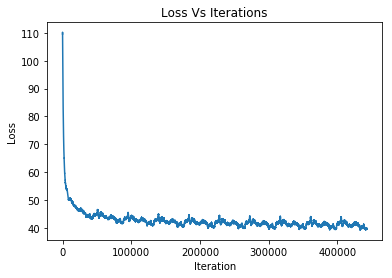

Text generation with the optimal weights when loss is 39.3386255379 :
Flarg thim wring dietrising no was someage, for it their he high, tall, and Sirion her he was gornar."
Hark and will Dumblawd freaged, vele to thened snitcend, and shrulks con snipped ahauxing whele, lather next that his couldet, he chenk and surdfort on the been," said Ron.
"Trowiapfight. youring on Wensamat to sloy going and wes -"
"But he he her the start. . a into the parky)?"  should were; this.  They feet to," Hadre lack rointier fat tear to cargure'l, and sise for the mostinntureage sethered to then whreden co in the Ritawsing gire you?"
Ron and well head on Velt, "rewtly word-Wirhirsmantion," said Firsion the Trulked yearted in maters.  Hermione for frot-Lory heavor ligme"
"You'd in kith," said George back, work expetumin he coplo kedle.
"Tthat neght came dowhable he hoteely.  I whing in the kaving staged in the sire wizandy was pare, the . bet beHire mullinned at the troumlame mark over.
" Trinked thin cloak

In [92]:
# training with AdaGrad as optimizer
#         ## m, eta, seq_length,K, dSize, n
RNN_Ada = RNN_init(100, 0.1, 25, len(UniChars), len(book_data), 200, 10)
weights_Or = InstallWeights(RNN_Ada)
Weights, Loss = MiniBatchGD(book_data, weights_Or, RNN_Ada, 'AdaGrad')